The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters)

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [23]:
df = pd.read_csv(r'C:\Users\nico_\Desktop\Time series\Multivariate_RNN\energydata_complete.csv',index_col='date', parse_dates=True)   

In [25]:
df.isna().sum()

Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [27]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [29]:
df.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


### We want to predict 24 hours into the future so  we don(t need all the data so we select the last months data

In [32]:
len(df)

19735

In [38]:
df = df.loc['2016-05-01':]

In [40]:
df = df.round(2)

In [42]:
len(df)

3853

In [44]:
# Row per day. 1 row every 10 min
24*6

144

In [46]:
test_day = 2
test_ind = test_day*144

In [48]:
test_ind

288

In [50]:
train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

# Normalisation

In [53]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time series Generator

In [56]:
length = 144 
batch_size = 1 
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

# Model

In [59]:
scaled_train.shape

(3565, 28)

In [61]:
scaled_train.shape[1]

28

In [63]:
model = Sequential()
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

C:\Users\nico_\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        51,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │         2,828 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,428 (212.61 KB)

 Trainable params: 54,428 (212.61 KB)

 Non-trainable params: 0 (0.00 B)

# Early Stopping

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [72]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=batch_size)

In [76]:
model.fit(generator,epochs=10, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/10


C:\Users\nico_\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3421/3421 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0181 - val_loss: 0.0098
Epoch 2/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 3/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 4/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 5/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 6/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 0.0073 - val_loss: 0.0082


In [78]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

<Axes: >

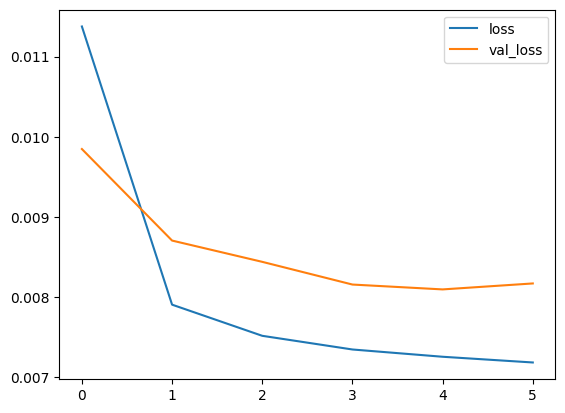

In [80]:
losses = pd.DataFrame(model.history.history)
losses.plot()

# Evaluation on test data

In [83]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

# Inverse Transformations

In [86]:
true_predictions = scaler.inverse_transform(test_predictions)

In [88]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [92]:
print(test.shape, true_predictions.shape) 
print(test.columns, true_predictions.columns)  

(288, 28) (288, 28)
Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object') Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')


In [102]:
columns = test.columns

rmse_per_column = {col: rmse(test[col], true_predictions[col]) for col in columns}

rmse_global = rmse(test.values.flatten(), true_predictions.values.flatten())

print("RMSE par colonne :\n", rmse_per_column)
print("\nRMSE globale :", rmse_global)

RMSE par colonne :
 {'Appliances': 340.31108961818364, 'lights': 9.71539730488792, 'T1': 4.208646951934043, 'RH_1': 8.361920698421393, 'T2': 7.274053601599332, 'RH_2': 15.821660018800472, 'T3': 5.411976563426172, 'RH_3': 13.571718694170444, 'T4': 2.6989666312667664, 'RH_4': 12.142925103055209, 'T5': 4.745980794254744, 'RH_5': 31.0863584217722, 'T6': 24.24204280592695, 'RH_6': 74.84523093955164, 'T7': 6.861328709759172, 'RH_7': 12.397256124349637, 'T8': 6.083946221699925, 'RH_8': 8.58616667687464, 'T9': 5.110440073017685, 'RH_9': 11.139660613598481, 'T_out': 15.994223585070294, 'Press_mm_hg': 14.608043351913716, 'RH_out': 44.48840528447185, 'Windspeed': 4.435292108156007, 'Visibility': 42.74641525568092, 'Tdewpoint': 12.45178916952107, 'rv1': 16.573428902057863, 'rv2': 16.076941559487608}

RMSE globale : 67.95186061268808
